In [1]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt

from copy import deepcopy as copy
# np.random.seed(1)

In [2]:
!pip install git+https://github.com/kilean20/pyTorchTemplate.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/kilean20/pyTorchTemplate.git to /tmp/pip-req-build-83ipax2_
  Running command git clone -q https://github.com/kilean20/pyTorchTemplate.git /tmp/pip-req-build-83ipax2_
  Created wheel for pyTorchTemplate: filename=pyTorchTemplate-0.0.1-py3-none-any.whl size=6602 sha256=95a408566376fddd199600ed435d25f3c0419a720a78d684c53d7672e3c578fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-801fsf20/wheels/15/b3/6d/10ca0e96789eddf8cbd29d87914215e75608e6930926678261
Successfully built pyTorchTemplate


In [3]:
!pip install git+https://github.com/kilean20/pyTorchTemplate.git --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/kilean20/pyTorchTemplate.git to /tmp/pip-req-build-ihrxzh6t
  Running command git clone -q https://github.com/kilean20/pyTorchTemplate.git /tmp/pip-req-build-ihrxzh6t
  Created wheel for pyTorchTemplate: filename=pyTorchTemplate-0.0.1-py3-none-any.whl size=6602 sha256=557f0d867b005fcfc3d17ccb135c42c6ae31cb69defdd2ef0e19936b3191d32a
  Stored in directory: /tmp/pip-ephem-wheel-cache-49oxt90i/wheels/15/b3/6d/10ca0e96789eddf8cbd29d87914215e75608e6930926678261
Successfully built pyTorchTemplate
  Attempting uninstall: pyTorchTemplate
    Found existing installation: pyTorchTemplate 0.0.1
    Uninstalling pyTorchTemplate-0.0.1:
      Successfully uninstalled pyTorchTemplate-0.0.1


In [4]:
import torch
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pyTorchTemplate as ptt

$$
\begin{eqnarray}
\boldsymbol{R} &=& |\boldsymbol{x}| \\
{f} &=& \frac{\sin(4\pi \boldsymbol{R})}{4\pi\boldsymbol{R}}
\end{eqnarray}
$$

In [5]:
ndim = 3
nSample = 1024
p = 6

In [6]:
def f(x):
    """The function to predict."""
    
    R = np.sqrt(np.sum(x**2,axis=1)) + 0.0001
    return np.sin(4*np.pi*R)/(4*np.pi*R)

# Prepare data

In [7]:
x_train = ((np.random.rand(nSample,ndim)-0.5)*2).astype(np.float32)
y_train = f(x_train).reshape(-1,1).astype(np.float32)

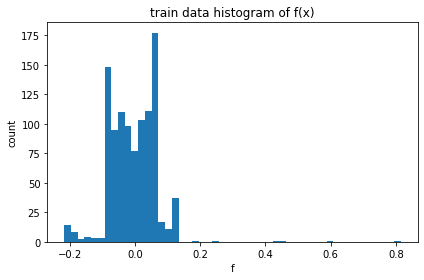

In [8]:
plt.hist(y_train,bins=50);
plt.xlabel('f')
plt.ylabel('count')
plt.title('train data histogram of f(x)')
plt.tight_layout()
plt.savefig('train_data_histo_'+str(ndim)+'D_'+str(nSample)+'sample.png',dpi=180)

In [9]:
x_test = ((np.random.rand(65536,ndim)-0.5)*2).astype(np.float32)
y_test = f(x_test).reshape(-1,1).astype(np.float32)

In [10]:
x_onAxis = np.zeros([256,ndim]).astype(np.float32)
x_onAxis[:,0] = np.linspace(-1, 1, 256)
y_onAxis = f(x_onAxis).reshape(-1,1).astype(np.float32)

In [11]:
train_data_loader = torch.utils.data.DataLoader(list(zip(x_train,y_train)),batch_size=128)
test_data_loader = torch.utils.data.DataLoader(list(zip(x_test,y_test)),batch_size=128)

### GP w/o dim-reduction

In [12]:
kernel = C(0.2, (1e-2, 1e2)) * RBF(1, (2e-2, 1e2))
gpNaive = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [13]:
gpNaive.score(x_train, y_train), gpNaive.score(x_test, y_test)

(-0.001563350384311546, -2.7915490699026435e-06)

In [14]:
gpNaive.fit(x_train, y_train)
gpNaive.kernel_

/usr/common/software/pytorch/v1.4.0/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.289**2 * RBF(length_scale=0.283)

In [15]:
gpNaive.score(x_train, y_train), gpNaive.score(x_test, y_test)   #(0.9999999999999998, 0.2938582961152787)

(0.999999999999771, 0.9946185780242578)

In [16]:
y_onAxis_GPnaive, sigma_GPnaive = gpNaive.predict(x_onAxis, return_std=True)
y_onAxis_GPnaive = y_onAxis_GPnaive.reshape(-1)

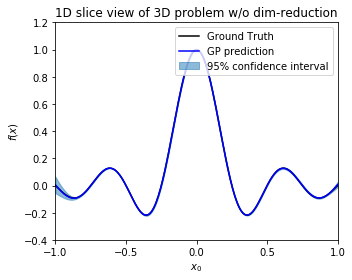

In [17]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_GPnaive, 'b-', label='GP prediction')
plt.fill_between(x_onAxis[:,0], 
                y_onAxis_GPnaive- 1.96 * sigma_GPnaive,
                y_onAxis_GPnaive+ 1.96 * sigma_GPnaive, 
                label='95% confidence interval', color='C0', alpha=.5, )
# plt.plot(x_onAxis[:,0],y_onAxis_NN, 'r-', label='NN prediction',lw=2,alpha=0.5)

plt.title('1D slice view of '+str(ndim)+'D problem w/o dim-reduction')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('GP_woDimReduct_'+str(ndim)+'D.png',dpi=180)

# with DimReduction

### AutoEncoderLike NN

In [18]:
def test(model,criterion,test_data_loader):
  model.eval()
  loss = 0 
  for x, y in test_data_loader:
    x = x.to(device)
    y_pred = model(x)
    loss += criterion(y_pred, y.to(device)).item()
  return loss/len(test_data_loader)

### 2D source

In [19]:
nsource = 2

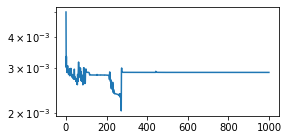

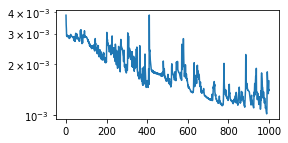

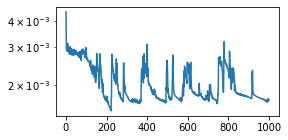

In [20]:
old_best_loss = 1
for i in range(10):
  model = ptt.resFCNN_autoEncoder([ndim,32,32,nsource],[nsource,16,16,1], torch.nn.CELU(inplace=True), residual=True, identity_block_every_layer=True)
  mode,hist = ptt.train_supervised(model,1.0e-2,200,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  tmp = test(model,ptt.MPELoss(p=p),train_data_loader)
  if tmp > 1:
    continue
  mode,hist = ptt.train_supervised(model,2.0e-3,1300,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  
  if newloss < old_best_loss:
    old_best_loss = newloss
    final_model = copy(model)
    final_hist  = copy(hist)
    
  if newloss < 1e-3:
    break
    
  plt.figure(figsize=(4,2))
  plt.semilogy(hist['train_loss'])
  plt.semilogy(hist['test_loss'])

model = final_model
hist = final_hist
mode,hist = ptt.train_supervised(model,5.0e-4,1500,
                                train_data_loader,
                                optimizer=torch.optim.Adam,
#                                 optim_args = {'weight_decay':0.2},
                                # data_loader,
                                old_hist = hist,
                                criterion=ptt.MPELoss(p=p),
                                old_best_loss = newloss,
                                dispHead = 0, dispTail = 0)
newloss = test(model,ptt.MPELoss(p=p),train_data_loader)


model = model.cpu()
model.eval();

In [21]:
model(torch.Tensor(x_train[:10,:])).detach().numpy()

array([[ 0.06225887],
       [-0.08451954],
       [-0.05462906],
       [-0.00366258],
       [ 0.002786  ],
       [ 0.06664652],
       [ 0.06769286],
       [ 0.06870519],
       [ 0.01970739],
       [-0.00029152]], dtype=float32)

In [22]:
f(x_train[:10,:])

array([ 0.05541382, -0.08487794, -0.06009905,  0.00065024, -0.00033233,
        0.06248715,  0.07057731,  0.07039326,  0.021362  ,  0.00281467],
      dtype=float32)

##### source from AutoEncoderLike BottleNeck

In [23]:
s_train = model.get_latent_variable(torch.Tensor(x_train)).detach().numpy()

[78.20227] [29.5714]
[78.20227, -15.3018875] [29.5714, 4.376315]


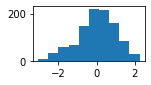

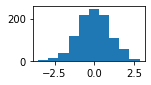

In [24]:
s_mean = []
s_std  = []

for i in range(nsource):
  s_mean.append(s_train[:,i].mean())
  s_std.append(s_train[:,i].std())
  print(s_mean,s_std)
  s_train[:,i] = (s_train[:,i]-s_mean[i])/s_std[i]
  plt.figure(figsize=(2,1))
  plt.hist(s_train[:,i]);

In [25]:
s_test = model.get_latent_variable(torch.Tensor(x_test)).detach().numpy()
for i in range(nsource):
  s_test[:,i] = (s_test[:,i]-s_mean[i])/s_std[i]

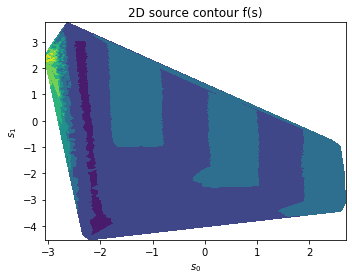

In [26]:
plt.figure(figsize=(5,4))
plt.tricontourf(s_test[:,0],s_test[:,1],y_test.reshape(-1))

plt.title(str(nsource)+'D source contour f(s)')
plt.xlabel(r'$s_0$')
plt.ylabel(r'$s_1$')
plt.tight_layout()
plt.savefig('4Dto2D_source_contour.png',dpi=180)

In [27]:
s_onAxis = model.get_latent_variable(torch.Tensor(x_onAxis)).detach().numpy()
for i in range(nsource):
  s_onAxis[:,i] = (s_onAxis[:,i]-s_mean[i])/s_std[i]

In [28]:
np.sqrt(newloss)

0.009438429430541373

##### GP on source

In [29]:
kernel = C(0.2, (5e-3, 5e2)) * RBF(1, (5e-3, 5e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=2*np.sqrt(newloss))

In [30]:
gp.score(s_train, y_train), gp.score(s_test, y_test)

(-0.001563350384311546, -2.7915490699026435e-06)

In [31]:
gp.fit(s_train, y_train)
gp.kernel_

0.168**2 * RBF(length_scale=0.731)

In [32]:
gp.score(s_train, y_train), gp.score(s_test, y_test)   

(0.9344606807262299, 0.7772670293383982)

##### on axis

In [33]:
y_onAxis_GP, sigma_GP = gp.predict(s_onAxis, return_std=True)
y_onAxis_GP = y_onAxis_GP.reshape(-1)
y_onAxis_NN = model(torch.Tensor(x_onAxis)).detach().numpy() 

In [34]:
y_onAxis_NN.shape

(256, 1)

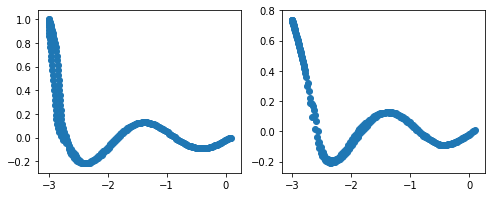

In [35]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(s_onAxis[:,0],y_onAxis)
plt.subplot(1,2,2)
plt.scatter(s_onAxis[:,0],y_onAxis_NN)

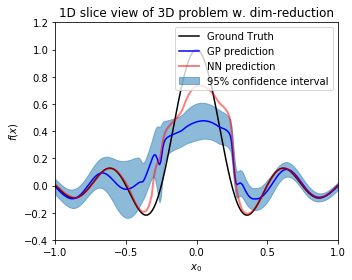

In [36]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_GP, 'b-', label='GP prediction')
plt.fill_between(x_onAxis[:,0], 
                y_onAxis_GP- 1.96 * sigma_GP,
                y_onAxis_GP+ 1.96 * sigma_GP, 
                label='95% confidence interval', color='C0', alpha=.5, )
plt.plot(x_onAxis[:,0],y_onAxis_NN, 'r-', label='NN prediction',lw=2,alpha=0.5)

plt.title('1D slice view of '+str(ndim)+'D problem w. dim-reduction')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('GP_wDimReduct_'+str(ndim)+'D_'+str(nsource)+'source.png',dpi=180)

In [37]:
ptt.count_parameters(model)

14838

### 1D source

In [38]:
nsource = 1

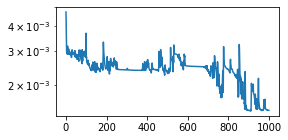

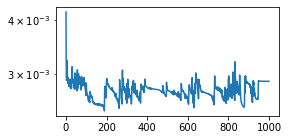

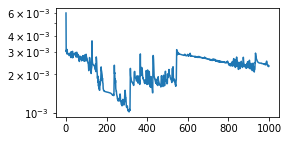

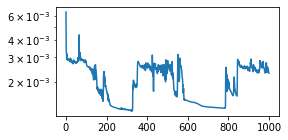

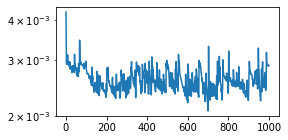

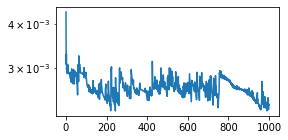

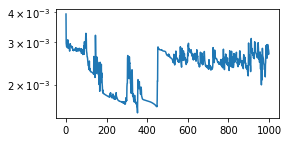

In [39]:
old_best_loss = 1
for i in range(10):
  model = ptt.resFCNN_autoEncoder([ndim,32,32,nsource],[nsource,16,16,1], torch.nn.CELU(inplace=True), residual=True, identity_block_every_layer=True)
  mode,hist = ptt.train_supervised(model,1.0e-2,200,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  tmp = test(model,ptt.MPELoss(p=p),train_data_loader)
  if tmp > 1:
    continue
  mode,hist = ptt.train_supervised(model,2.0e-3,1300,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  
  if newloss < old_best_loss:
    old_best_loss = newloss
    final_model = copy(model)
    final_hist  = copy(hist)
    
  if newloss < 1e-3:
    break
    
  plt.figure(figsize=(4,2))
  plt.semilogy(hist['train_loss'])
  plt.semilogy(hist['test_loss'])

model = final_model
hist = final_hist
mode,hist = ptt.train_supervised(model,5.0e-4,1500,
                                train_data_loader,
                                optimizer=torch.optim.Adam,
#                                 optim_args = {'weight_decay':0.2},
                                # data_loader,
                                old_hist = hist,
                                criterion=ptt.MPELoss(p=p),
                                old_best_loss = newloss,
                                dispHead = 0, dispTail = 0)
newloss = test(model,ptt.MPELoss(p=p),train_data_loader)


model = model.cpu()
model.eval();

8.159540266206022e-05

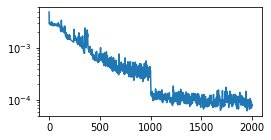

In [40]:
plt.figure(figsize=(4,2))
plt.semilogy(hist['train_loss'])
plt.semilogy(hist['test_loss'])
newloss

In [41]:
model(torch.Tensor(x_train[:10,:])).detach().numpy()

array([[ 0.05642433],
       [-0.08348331],
       [-0.05921825],
       [ 0.00425699],
       [-0.00498688],
       [ 0.06105834],
       [ 0.06768401],
       [ 0.06714135],
       [ 0.02277925],
       [ 0.0072796 ]], dtype=float32)

In [42]:
f(x_train[:10,:])

array([ 0.05541382, -0.08487794, -0.06009905,  0.00065024, -0.00033233,
        0.06248715,  0.07057731,  0.07039326,  0.021362  ,  0.00281467],
      dtype=float32)

##### source from AutoEncoderLike BottleNeck

In [43]:
s_train = model.get_latent_variable(torch.Tensor(x_train)).detach().numpy()

[-30.197367] [10.3200655]


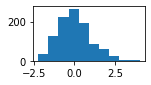

In [44]:
s_mean = []
s_std  = []

for i in range(nsource):
  s_mean.append(s_train[:,i].mean())
  s_std.append(s_train[:,i].std())
  print(s_mean,s_std)
  s_train[:,i] = (s_train[:,i]-s_mean[i])/s_std[i]
  plt.figure(figsize=(2,1))
  plt.hist(s_train[:,i]);

In [45]:
s_test = model.get_latent_variable(torch.Tensor(x_test)).detach().numpy()
for i in range(nsource):
  s_test[:,i] = (s_test[:,i]-s_mean[i])/s_std[i]

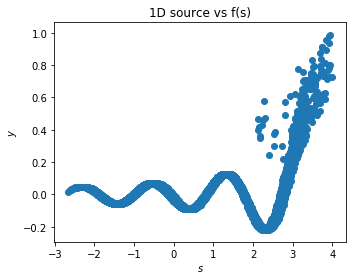

In [46]:
plt.figure(figsize=(5,4))
plt.scatter(s_test[:,0],y_test.reshape(-1))

plt.title(str(nsource)+'D source vs f(s)')
plt.xlabel(r'$s$')
plt.ylabel(r'$y$')
plt.tight_layout()
plt.savefig('4Dto1D_source_contour.png',dpi=180)

In [47]:
s_onAxis = model.get_latent_variable(torch.Tensor(x_onAxis)).detach().numpy()
for i in range(nsource):
  s_onAxis[:,i] = (s_onAxis[:,i]-s_mean[i])/s_std[i]

##### GP on source

In [48]:
kernel = C(0.2, (5e-3, 5e2)) * RBF(1, (5e-3, 5e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=2*np.sqrt(newloss))

In [49]:
gp.score(s_train, y_train), gp.score(s_test, y_test)

(-0.001563350384311546, -2.7915490699026435e-06)

In [50]:
gp.fit(s_train, y_train)
gp.kernel_

0.344**2 * RBF(length_scale=0.817)

In [51]:
gp.score(s_train, y_train), gp.score(s_test, y_test)   

(0.9952323077006848, 0.9720337919292107)

##### on axis

In [52]:
y_onAxis_GP, sigma_GP = gp.predict(s_onAxis, return_std=True)
y_onAxis_GP = y_onAxis_GP.reshape(-1)
y_onAxis_NN = model(torch.Tensor(x_onAxis)).detach().numpy() 

In [53]:
y_onAxis_NN.shape

(256, 1)

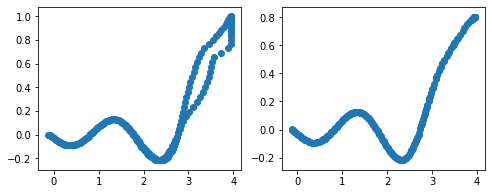

In [54]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(s_onAxis[:,0],y_onAxis)
plt.subplot(1,2,2)
plt.scatter(s_onAxis[:,0],y_onAxis_NN)

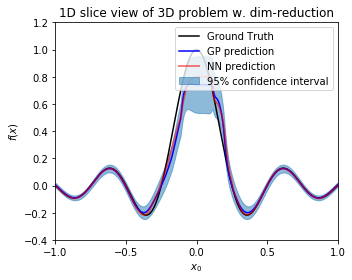

In [55]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_GP, 'b-', label='GP prediction')
plt.fill_between(x_onAxis[:,0], 
                y_onAxis_GP- 1.96 * sigma_GP,
                y_onAxis_GP+ 1.96 * sigma_GP, 
                label='95% confidence interval', color='C0', alpha=.5, )
plt.plot(x_onAxis[:,0],y_onAxis_NN, 'r-', label='NN prediction',lw=2,alpha=0.5)

plt.title('1D slice view of '+str(ndim)+'D problem w. dim-reduction')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('GP_wDimReduct_'+str(ndim)+'D_'+str(nsource)+'source.png',dpi=180)

In [56]:
ptt.count_parameters(model)

14780